# Anomaly Detection System

In [1]:
# Standard library imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Third party imports
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import time

# Optuna specific imports
import optuna

#Sklearn imports
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

C:\Users\IDP L3\AppData\Local\Temp\ipykernel_17544\484529611.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\IDP L3\Desktop\crypto_mini\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessed Dataset

In [2]:
df=pd.read_csv('./data/BitcoinHeistDataPreProcessed.csv')
df

,address,year,day,length,weight,count,looped,neighbors,income,n_address_feature,...,cybercrime_related,length_weight,count_looped,month,week,total_volume,average_volume,transaction_frequency,cluster,label
0,0.000253,0.857961,0.062835,0.627489,0.012028,0.000000,0.0,0.298088,0.277443,0.0,...,0.0,0.096372,0.0,0.000000,0.038482,0.232624,0.273815,0.000000,0.0,2
1,0.000894,0.715614,0.468752,0.791121,0.000356,0.000000,0.0,0.000000,0.277343,0.0,...,0.0,0.007715,0.0,0.406922,0.442411,0.232539,0.273717,0.000000,0.0,2
2,0.001092,0.715614,0.746693,0.000000,0.643462,0.000000,0.0,0.298088,0.404329,0.0,...,0.0,0.000000,0.0,0.722043,0.739832,0.343862,0.399690,0.000000,0.0,2
3,0.001307,0.715614,0.911565,0.879278,0.005668,0.000000,0.0,0.298088,0.206999,0.0,...,0.0,0.164511,0.0,0.864469,0.911197,0.172304,0.204123,0.000000,0.0,2
4,0.001620,0.715614,0.728573,1.000000,0.097573,0.950441,0.0,0.000000,0.404329,0.0,...,0.0,0.832317,0.0,0.647649,0.723597,0.343862,0.399690,0.913812,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701898,0.940333,1.000000,0.928253,0.695205,0.643462,0.000000,0.0,0.298088,0.339108,0.0,...,0.0,0.911794,0.0,0.933001,0.926201,0.286241,0.334930,0.000000,0.0,3
2701899,0.938638,1.000000,0.928253,0.834516,0.057826,0.000000,0.0,0.298088,0.486375,0.0,...,0.0,0.583298,0.0,0.933001,0.926201,0.417838,0.481345,0.000000,0.0,3
2701900,0.043670,1.000000,0.928253,0.000000,0.142686,0.000000,0.0,0.000000,0.654789,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.576069,0.649756,0.000000,0.0,3
2701901,0.879521,1.000000,0.928253,0.000000,0.643462,0.000000,0.0,0.000000,0.097552,0.0,...,0.0,0.000000,0.0,0.933001,0.926201,0.080349,0.096080,0.000000,0.0,3


In [3]:
#Distribution of Labels
df['label'].value_counts()

label
3    2671631
2      15256
1       8099
0       6917
Name: count, dtype: int64

Data Preprocessing

In [4]:
# The label Montreal is encoded as 0
# The label Padua is encoded as 1
# The label Princeton is encoded as 2
# The label White is encoded as 3

# df1: designated ransomware (1)
# df2: other ransomwares (1)
# df3: white (0)

# Variable for designated attack - Montreal
designated_attack = 0

# df1: designated attack (1) Montreal White
df1 = df[df['label'] == designated_attack].copy()
df1['label'] = 1  # Transfer its original label to 1

# df2: other attacks (1) - Princeton Padua White
df2 = df[(df['label'] != designated_attack) & (df['label'] != 3)].copy()
df2['label'] = 1  # Transfer other attacks’ label to 1

# df3: white (0)
df3 = df[df['label'] == 3].copy()

# Shuffle df3
df3 = df3.sample(frac=1, random_state=1)

# Calculate the number of samples for training and testing
num_train_samples = len(df2)
num_test_samples = len(df1)

# Split df3 into two parts for training and testing
df3_train = df3.iloc[:num_train_samples].copy()
#start at the row number equal to num_train_samples, and end at the row number equal to num_train_samples + num_test_samples".
df3_test = df3.iloc[num_train_samples:num_train_samples + num_test_samples].copy()

# Set the labels
df3_train['label'] = 0
df3_test['label'] = 0

# Create the training and testing dataframes
training_df = pd.concat([df2, df3_train])
test_df = pd.concat([df1, df3_test])

# For the training data
X_train = training_df.drop('label', axis=1)
y_train = training_df['label']

# For the test data
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Feature selection

Original features: Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'n_address_feature', 'quarter_number',
       'is_close_to_holiday', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior',
       'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency', 'cluster'],
      dtype='object')
Selected features: Index(['address', 'year', 'day', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior', 'total_volume',
       'average_volume'],
      dtype='object')
Not selected features: Index(['length', 'count', 'looped', 'quarter_number', 'is_close_to_holiday',
       'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
       'transaction_frequency', 'cluster'],
      dty

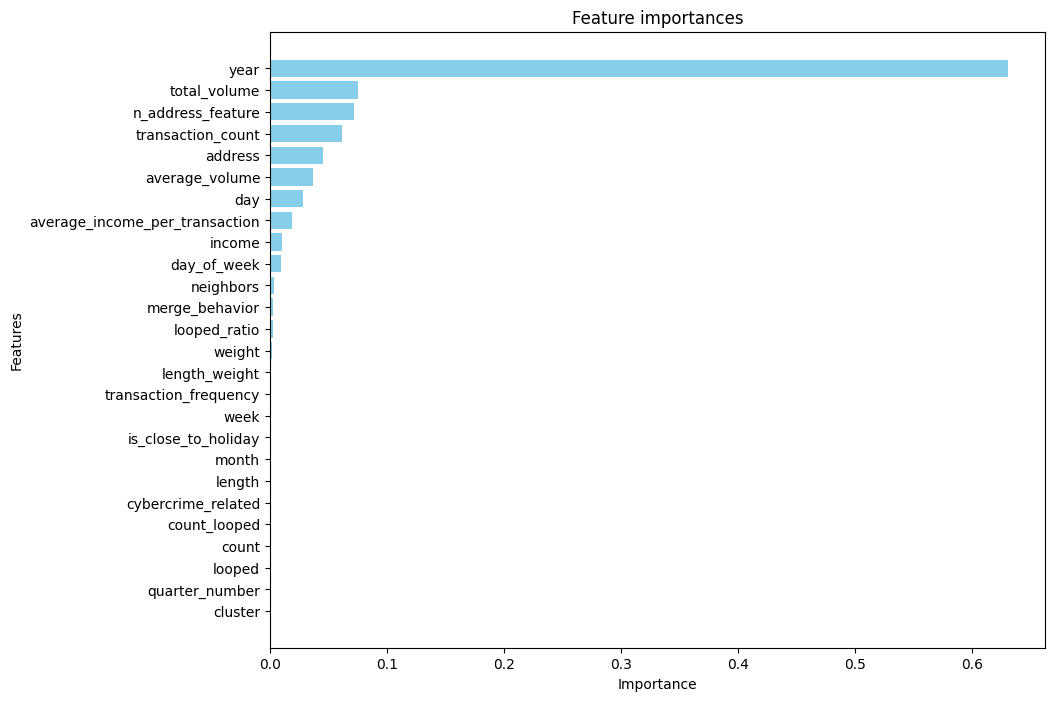

In [5]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)

# Print the feature names before selection
original_feature_names = X_train.columns  # Get feature names from the training data
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Create a boolean mask of features selected by the model
mask = importances > 0.001  

# Apply the mask to the feature dataset
X_train_new = X_train.loc[:, mask]  
X_test_new = X_test.loc[:, mask]

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()

plt.show()

In [6]:
# Create copies of the original X_train and X_test
X_train_initial = X_train.copy()
X_test_initial = X_test.copy()

[I 2024-04-13 11:27:41,722] A new study created in memory with name: no-name-02094df2-d62b-4dbd-bc5f-9dfbe0ac00f6


Original features: Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'n_address_feature', 'quarter_number',
       'is_close_to_holiday', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior',
       'cybercrime_related', 'length_weight', 'count_looped', 'month', 'week',
       'total_volume', 'average_volume', 'transaction_frequency', 'cluster'],
      dtype='object')


[I 2024-04-13 11:28:05,676] Trial 0 finished with value: 0.9324127595803896 and parameters: {'threshold': 0.0026059032898610945}. Best is trial 0 with value: 0.9324127595803896.
[I 2024-04-13 11:28:29,052] Trial 1 finished with value: 0.9300149860843503 and parameters: {'threshold': 0.004021961886434436}. Best is trial 0 with value: 0.9324127595803896.
[I 2024-04-13 11:28:52,877] Trial 2 finished with value: 0.9300149860843503 and parameters: {'threshold': 0.005783967755362345}. Best is trial 0 with value: 0.9324127595803896.
[I 2024-04-13 11:29:16,436] Trial 3 finished with value: 0.9300149860843503 and parameters: {'threshold': 0.008708138018437745}. Best is trial 0 with value: 0.9324127595803896.
[I 2024-04-13 11:29:48,865] Trial 4 finished with value: 0.93538856775851 and parameters: {'threshold': 0.0004157962728103071}. Best is trial 4 with value: 0.93538856775851.
[I 2024-04-13 11:30:13,072] Trial 5 finished with value: 0.9300149860843503 and parameters: {'threshold': 0.009005544

Best threshold: 0.0004157962728103071
Best score: 0.93538856775851
Selected features: Index(['address', 'year', 'day', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior', 'length_weight',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')
Not selected features: Index(['length', 'count', 'looped', 'quarter_number', 'is_close_to_holiday',
       'cybercrime_related', 'count_looped', 'month', 'week', 'cluster'],
      dtype='object')


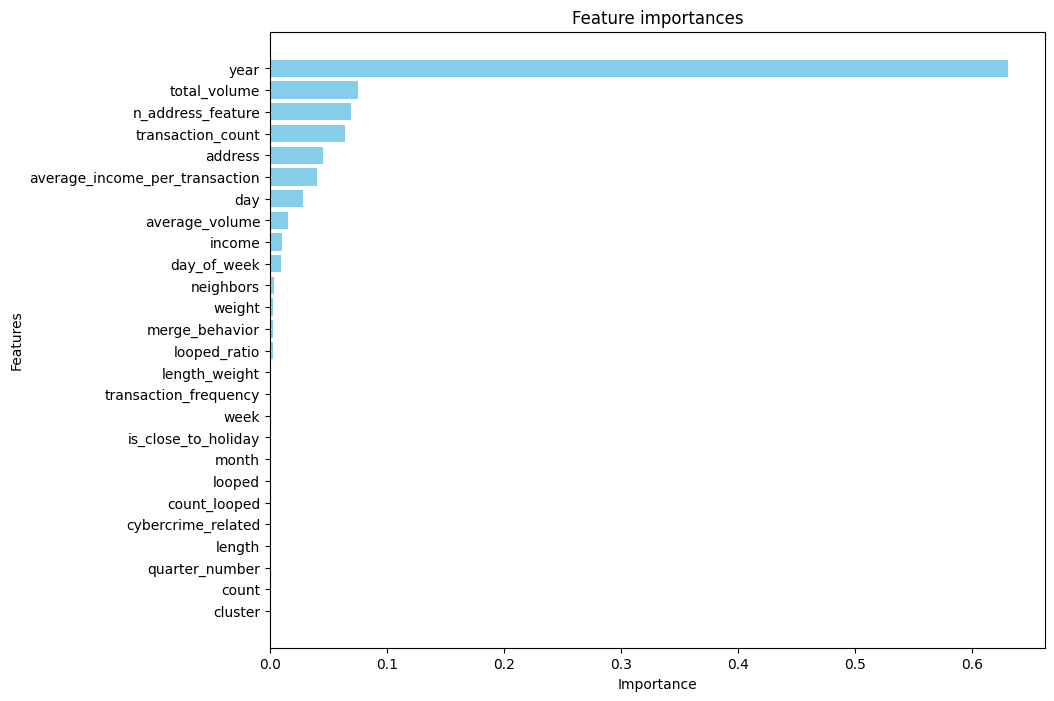

In [7]:
# Feature selection
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)

# Print the feature names before selection
original_feature_names = X_train.columns
print('Original features: {}'.format(original_feature_names))

# Get feature importances
importances = gb.feature_importances_

# Define an objective function to be minimized.
def objective(trial, X_train, y_train):
    # Suggest a threshold for the feature selection
    threshold = trial.suggest_float('threshold', 0, 0.01)

    # Create a mask for the current threshold
    mask = importances > threshold

    # Apply the mask to the training data
    X_train_new = X_train.loc[:, mask]
    
    # If all features are filtered out, return a large negative value
    if X_train_new.empty:
        return -1e9
    
    # Fit the model and evaluate its performance
    gb.fit(X_train_new, y_train)
    score = gb.score(X_train_new, y_train)

    # Return the score
    return score

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)

# Get the best trial
best_trial = study.best_trial

print('Best threshold: {}'.format(best_trial.params['threshold']))
print('Best score: {}'.format(best_trial.value))

# Apply the best threshold to the feature dataset
mask = importances > best_trial.params['threshold']
X_train_new = X_train.loc[:, mask]
X_test_new = X_test.loc[:, mask]

# Print the selected feature names
selected_feature_names = X_train_new.columns
print('Selected features: {}'.format(selected_feature_names))

# Print the features that are not selected
not_selected_feature_names = original_feature_names[~mask]
print('Not selected features: {}'.format(not_selected_feature_names))

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': original_feature_names, 'importance': importances})

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot feature importances with feature names
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importances")
plt.gca().invert_yaxis()

plt.show()

In [8]:
# Transfer X_train_new to X_train
X_train = X_train_new.copy()

# Transfer X_test_new to X_test
X_test = X_test_new.copy()

# Update the feature names to match the selected features
selected_feature_names = X_train.columns
print('Updated X_train with selected features: {}'.format(selected_feature_names))

selected_feature_names = X_test.columns
print('Updated X_test with selected features: {}'.format(selected_feature_names))

Updated X_train with selected features: Index(['address', 'year', 'day', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior', 'length_weight',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')
Updated X_test with selected features: Index(['address', 'year', 'day', 'weight', 'neighbors', 'income',
       'n_address_feature', 'day_of_week', 'average_income_per_transaction',
       'transaction_count', 'looped_ratio', 'merge_behavior', 'length_weight',
       'total_volume', 'average_volume', 'transaction_frequency'],
      dtype='object')


In [9]:
df1['label'].value_counts()

label
1    6917
Name: count, dtype: int64

In [10]:
df2['label'].value_counts()

label
1    23355
Name: count, dtype: int64

In [11]:
df3['label'].value_counts()

label
3    2671631
Name: count, dtype: int64

In [12]:
training_df['label'].value_counts()

label
1    23355
0    23355
Name: count, dtype: int64

In [13]:
test_df['label'].value_counts()

label
1    6917
0    6917
Name: count, dtype: int64

# Cluster labeling (CL) k-means method

In [ ]:
# 0 is normal, 1 is attack
# a is attack, b is normal (the number of attack or normal in each cluster)
# list1 is normal, list2 is attack (the list to store labeled cluster)

def CL_kmeans(X_train, X_test, y_train, y_test, n, b=100):
    #1)Unsupervised Phase
    km_cluster = MiniBatchKMeans(n_clusters=n, batch_size=b, random_state=0)
    # Prediction1: predict which cluster the training data belongs to 0-19
    y_train_pred = km_cluster.fit_predict(X_train) 
    
    # calculate the internal attack or white number
    a = np.zeros(n)
    b = np.zeros(n)
    for v in range(n):
        a[v] = np.sum((y_train_pred == v) & (y_train == 1))
        b[v] = np.sum((y_train_pred == v) & (y_train == 0))
    # label each cluster
    list1 = np.where(a <= b)[0]
    list2 = np.where(a > b)[0]
    
    # 2)Supervised Phase
    start_time = time.time()
    result_ClusterPrediction_test = km_cluster.predict(X_test)
    # Converts cluster indexes to attack/normal index using list1
    y_test_pred = np.where(np.isin(result_ClusterPrediction_test, list1), 0, 1)
    end_time = time.time()
    prediction_time = end_time - start_time

    epsilon = 1e-10
    cluster_confidence = np.where(a <= b, b / (a + b + epsilon), a / (a + b + epsilon))
    confidence_test = cluster_confidence[result_ClusterPrediction_test]
    confidence_train = cluster_confidence[y_train_pred]

    cm = confusion_matrix(y_test, y_test_pred)
    acc = accuracy_score(y_test, y_test_pred)

    cluster_to_confidence_count = defaultdict(int)
    for i, cluster in enumerate(result_ClusterPrediction_test):
        cluster_to_confidence_count[(cluster, confidence_test[i])] += 1
        
    # Reset the index of y_test and X_test
    y_test = y_test.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    # Reset the index of y_train and X_train
    y_train = y_train.reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)

    # Predict labels for training data
    y_train_pred_label = np.where(np.isin(y_train_pred, list1), 0, 1)

    # Get instances of TP, TN, FP, FN
    TP_instances = X_train[(y_train == 1) & (y_train_pred_label == 1)]
    TN_instances = X_train[(y_train == 0) & (y_train_pred_label == 0)]
    FP_instances = X_train[(y_train == 0) & (y_train_pred_label == 1)]
    FN_instances = X_train[(y_train == 1) & (y_train_pred_label == 0)]

    return confidence_train, confidence_test, cm, cluster_confidence, y_test_pred, acc, cluster_to_confidence_count, TP_instances, TN_instances, FP_instances, FN_instances, prediction_time

Accuracy: 0.721989301720399
Prediction time: 0.005108356475830078 seconds
Precision: 0.747687251470089
Recall: 0.721989301720399
F1 score: 0.7145862685763182


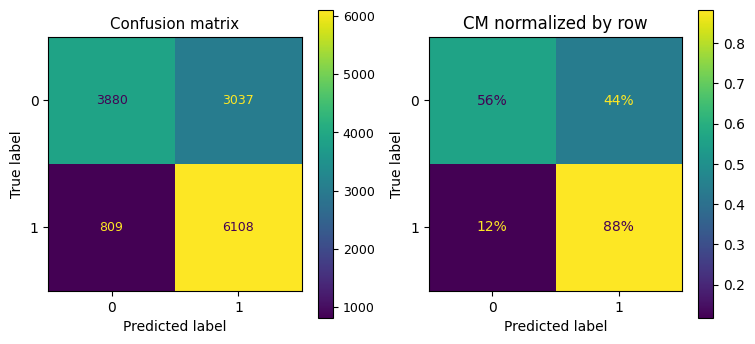

<Figure size 640x480 with 0 Axes>

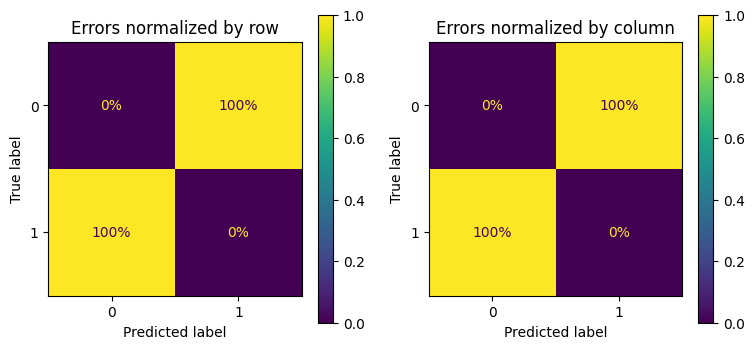

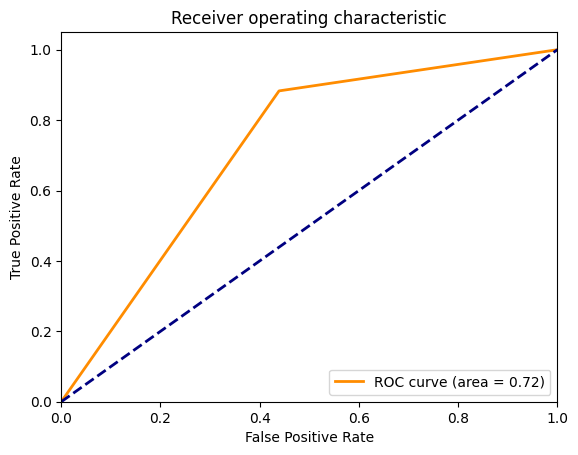

In [15]:
# Apply the modified CL_kmeans function
confidence_train, confidence_test, cm, cluster_confidence, y_test_pred, acc, cluster_to_confidence_count, TP_instances, TN_instances, FP_instances, FN_instances, prediction_time = CL_kmeans(X_train, X_test, y_train, y_test,20)

# Calculate metrics
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

print('Accuracy:', acc)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix
sample_weight = (y_test_pred != y_test)

# Part 1
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format=".0%", ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()

plt.clf() 

# Part 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
axs[1].set_title("Errors normalized by column")
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


[I 2024-04-13 11:40:32,263] A new study created in memory with name: no-name-d4ba35de-ac75-407b-81c8-203743996002


[I 2024-04-13 11:40:33,603] Trial 0 finished with value: 0.6960387451207171 and parameters: {'n': 608}. Best is trial 0 with value: 0.6960387451207171.
[I 2024-04-13 11:40:34,465] Trial 1 finished with value: 0.6953881740639005 and parameters: {'n': 417}. Best is trial 0 with value: 0.6960387451207171.
[I 2024-04-13 11:40:35,349] Trial 2 finished with value: 0.7062310250108429 and parameters: {'n': 479}. Best is trial 2 with value: 0.7062310250108429.
[I 2024-04-13 11:40:36,605] Trial 3 finished with value: 0.6964001734856151 and parameters: {'n': 114}. Best is trial 2 with value: 0.7062310250108429.
[I 2024-04-13 11:40:38,769] Trial 4 finished with value: 0.7097007373138644 and parameters: {'n': 977}. Best is trial 4 with value: 0.7097007373138644.
[I 2024-04-13 11:40:39,139] Trial 5 finished with value: 0.6827381812924679 and parameters: {'n': 270}. Best is trial 4 with value: 0.7097007373138644.
[I 2024-04-13 11:40:41,379] Trial 6 finished with value: 0.6867861789793263 and paramete


Best parameters:
{'n': 8}
Accuracy: 0.7720832730952725
Prediction time: 0.005999565124511719 seconds
Precision: 0.7722381837807886
Recall: 0.7720832730952725
F1 score: 0.7720508458295186


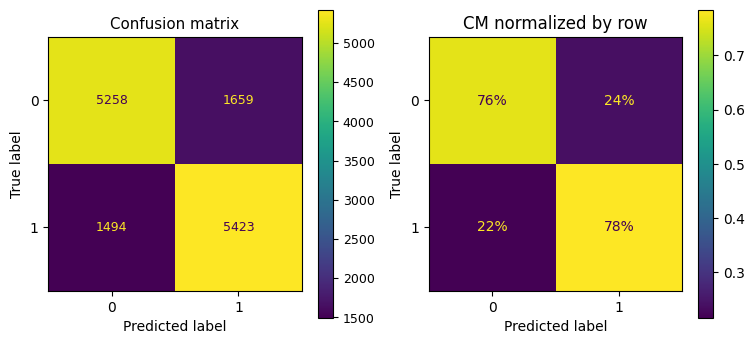

<Figure size 640x480 with 0 Axes>

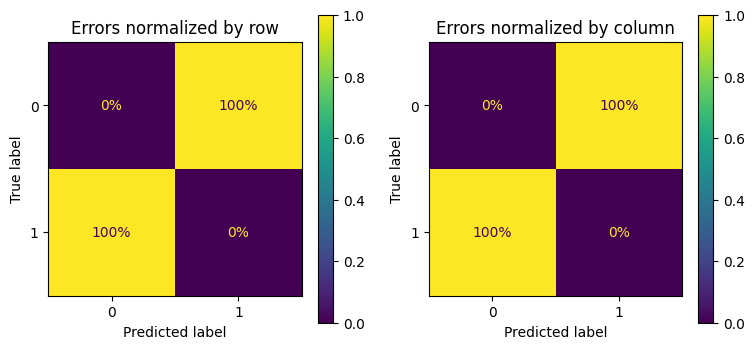

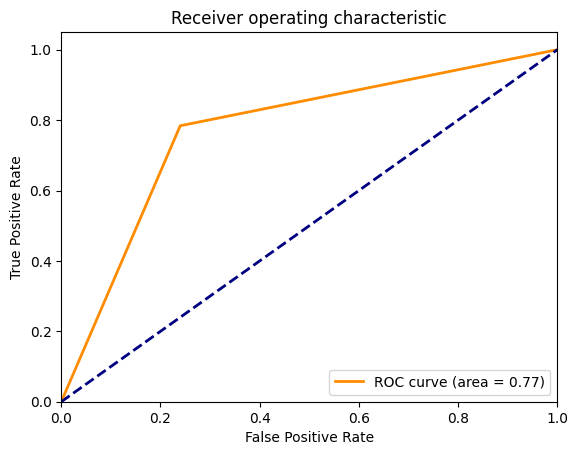

In [16]:
import optuna

def objective(trial):
    n = trial.suggest_int('n', 2, 1000)  # suggest a value for n between 1 and 200

    # Call the modified CL_kmeans function
    _, _, _, _, y_test_pred, acc, _, _, _, _, _,_ = CL_kmeans(X_train, X_test, y_train, y_test, n)

    # Return the accuracy
    return acc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters
print("\nBest parameters:")
print(study.best_params)

# Call the modified CL_kmeans function with the best parameters
confidence_train, confidence_test, cm, cluster_confidence, y_test_pred, acc, cluster_to_confidence_count, TP_instances, TN_instances, FP_instances, FN_instances, prediction_time = CL_kmeans(X_train, X_test, y_train, y_test, study.best_params['n'])

# Calculate metrics
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

print('Accuracy:', acc)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix
sample_weight = (y_test_pred != y_test)

# Part 1
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize="true", values_format=".0%", ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()

plt.clf()

# Part 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
axs[1].set_title("Errors normalized by column")
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Apply the CL-k-means model with biased classifiers

True Positives (TP): These are the instances that were actually positive and the model correctly predicted them as positive. In this case, these are the instances where the actual label was 1 (attack) and the model also predicted them as 1.

True Negatives (TN): These are the instances that were actually negative and the model correctly predicted them as negative. In this case, these are the instances where the actual label was 0 (normal) and the model also predicted them as 0.

False Positives (FP): These are the instances that were actually negative but the model incorrectly predicted them as positive. In this case, these are the instances where the actual label was 0 (normal) but the model predicted them as 1 (attack).

False Negatives (FN): These are the instances that were actually positive but the model incorrectly predicted them as negative. In this case, these are the instances where the actual label was 1 (attack) but the model predicted them as 0 (normal).

In [17]:
from xgboost import XGBClassifier
from sklearn.utils import resample
import numpy as np

def CL_kmeans_with_biasedClassifer(X_train, X_test, y_train, y_test, n, threshold, b=100):
    # Reset the index
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    # Run the original CL_kmeans function
    confidence_train, confidence_test, cm, cluster_confidence, y_test_pred, acc, cluster_to_confidence_count, TP_instances, TN_instances, FP_instances, FN_instances, prediction_time = CL_kmeans(X_train, X_test, y_train, y_test, n, b)
    
    # Get the same amount of randomly sampled normal and attack data
    if len(FN_instances) <= len(TN_instances) and len(FP_instances) <= len(TP_instances):
        normal_data = resample(TN_instances, n_samples=len(FN_instances),random_state=0)
        attack_data = resample(TP_instances, n_samples=len(FP_instances),random_state=0)
    else:
        print("FN_instances or FP_instances is larger than TN_instances or TP_instances. Please check your data.")

    
    # Train the first biased classifier, B1, on all the FN_instances along with the same amount of randomly sampled normal data
    B1 = XGBClassifier(random_state=0)
    B1.fit(np.concatenate((FN_instances, normal_data)), np.concatenate((np.ones(len(FN_instances)), np.zeros(len(normal_data)))))
    
    # Train the second biased classifier, B2, on all the FP_instances along with the same amount of randomly sampled attack data
    B2 = XGBClassifier(random_state=0)
    B2.fit(np.concatenate((FP_instances, attack_data)), np.concatenate((np.zeros(len(FP_instances)), np.ones(len(attack_data)))))
    
    start_time1 = time.time()
    # Apply the biased classifiers to the test data
    y_test_pred_B1 = B1.predict(X_test)
    y_test_pred_B2 = B2.predict(X_test)
    # If the confidence is lower than the threshold, pass the uncertain instance to B1 or B2
    y_test_pred_final = np.where(confidence_test < threshold, np.where(y_test_pred == 0, y_test_pred_B1, y_test_pred_B2), y_test_pred)
    end_time1 = time.time()
    prediction_time=prediction_time+end_time1-start_time1
    
    
    return y_test_pred_final, prediction_time


Accuracy: 0.721989301720399
Prediction time: 0.1309800148010254 seconds
Precision: 0.747687251470089
Recall: 0.721989301720399
F1 score: 0.7145862685763182


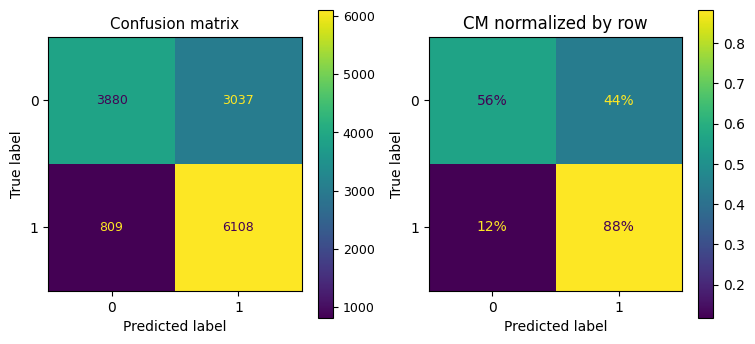

<Figure size 640x480 with 0 Axes>

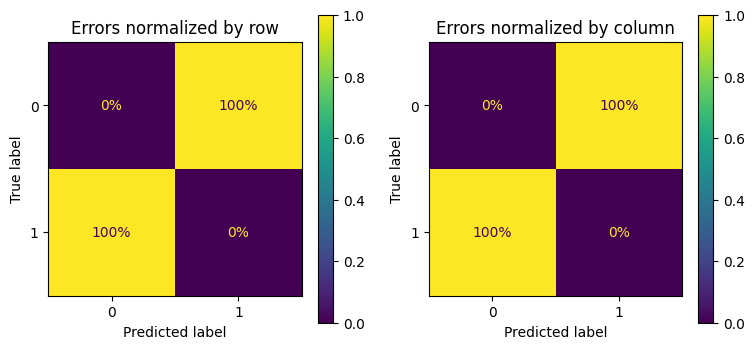

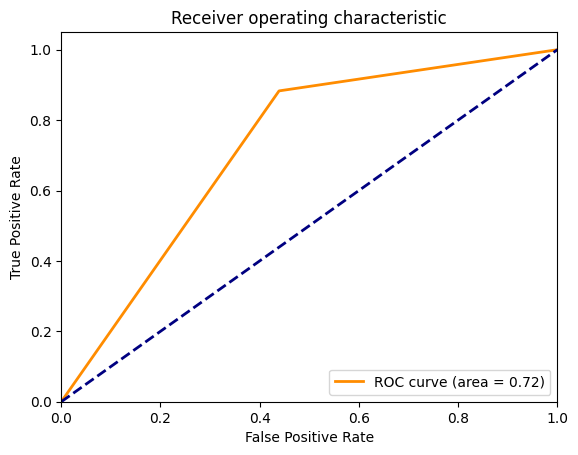

In [18]:
# Apply the modified CL_kmeans function
y_test_pred_final, prediction_time = CL_kmeans_with_biasedClassifer(X_train, X_test, y_train, y_test, 20, threshold=0.5)

# Calculate metrics
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_test_pred_final, average='weighted')
acc = accuracy_score(y_test, y_test_pred_final)

print('Accuracy:', acc)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix 
sample_weight = (y_test_pred_final != y_test)

# Part 1
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, normalize="true", values_format=".0%", ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()

plt.clf() 

# Part 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
axs[1].set_title("Errors normalized by column")
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_test_pred_final)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_final)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


[I 2024-04-13 11:43:50,477] A new study created in memory with name: no-name-8e949234-3cb3-42b2-b1ec-2cc4455899ff


[I 2024-04-13 11:43:54,854] Trial 0 finished with value: 0.6930027468555732 and parameters: {'n': 851, 'threshold': 0.5497789125963124}. Best is trial 0 with value: 0.6930027468555732.
[I 2024-04-13 11:43:57,199] Trial 1 finished with value: 0.5683822466387162 and parameters: {'n': 9, 'threshold': 0.8992024987484208}. Best is trial 0 with value: 0.6930027468555732.
[I 2024-04-13 11:43:59,535] Trial 2 finished with value: 0.7171461616307648 and parameters: {'n': 185, 'threshold': 0.8654660533887699}. Best is trial 2 with value: 0.7171461616307648.
[I 2024-04-13 11:44:02,910] Trial 3 finished with value: 0.6973398872343501 and parameters: {'n': 827, 'threshold': 0.7917547862231229}. Best is trial 2 with value: 0.7171461616307648.
[I 2024-04-13 11:44:04,676] Trial 4 finished with value: 0.6308370680931039 and parameters: {'n': 620, 'threshold': 0.9207038562932763}. Best is trial 2 with value: 0.7171461616307648.
[I 2024-04-13 11:44:05,841] Trial 5 finished with value: 0.6835333236952436 a


Best parameters:
{'n': 4, 'threshold': 0.6756997492917584}
Accuracy: 0.8202255312996964
Prediction time: 0.04352903366088867 seconds
Precision: 0.8202379071229586
Recall: 0.8202255312996964
F1 score: 0.820223794404643


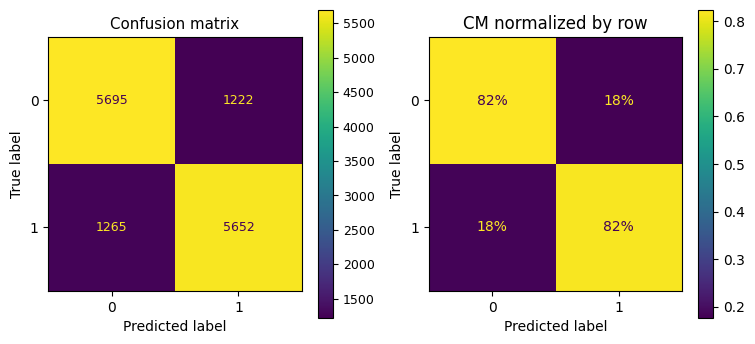

<Figure size 640x480 with 0 Axes>

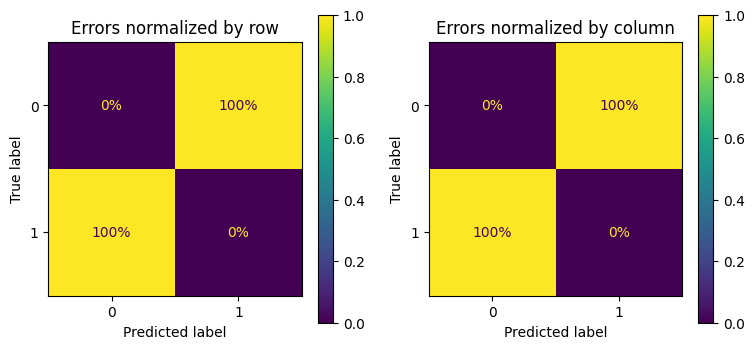

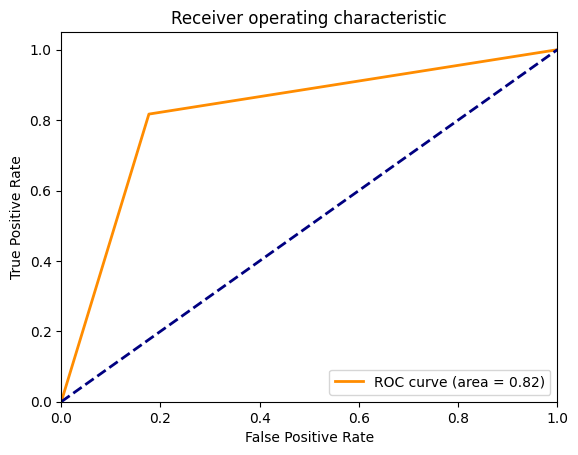

In [19]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    n = trial.suggest_int('n', 2, 1000)  # suggest a value for n between 1 and 50
    threshold = trial.suggest_uniform('threshold', 0.2, 1)  # suggest a value for threshold between 0.1 and 1

    # Run the function and get the predicted labels
    y_test_pred_final,prediction_time = CL_kmeans_with_biasedClassifer(X_train, X_test, y_train, y_test, n, threshold)

    # Calculate the accuracy score
    score = accuracy_score(y_test, y_test_pred_final)

    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters
print("\nBest parameters:")
print(study.best_params)

# Apply the modified CL_kmeans function
y_test_pred_final, prediction_time = CL_kmeans_with_biasedClassifer(X_train, X_test, y_train, y_test, study.best_params['n'], study.best_params['threshold'])

# Calculate metrics
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_test_pred_final, average='weighted')
acc = accuracy_score(y_test, y_test_pred_final)

print('Accuracy:', acc)
print('Prediction time:', prediction_time, 'seconds')
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f_score)

# Confusion Matrix and save it as PDF
sample_weight = (y_test_pred_final != y_test)

# Part 1
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, normalize="true", values_format=".0%", ax=axs[1])
axs[1].set_title("CM normalized by row")
plt.show()
plt.clf()

# Part 2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, sample_weight=sample_weight, normalize="true", values_format=".0%", ax=axs[0])
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_final, sample_weight=sample_weight, normalize="pred", values_format=".0%", ax=axs[1])
axs[1].set_title("Errors normalized by column")
plt.show()

# ROC Curve and save it as PDF
roc_auc = roc_auc_score(y_test, y_test_pred_final)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_final)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()